# APRE Benchmark Database
<!--- jupyter nbconvert --execute --to markdown README.ipynb* --->

## Getting Started

```
git clone ...
cd apre-benchmark-database
python3 -m pip install --upgrade pip
touch setup.cfg
pip install -e. 
rm setup.cfg
```

In [4]:
from APREdatabase import *
from APREmeasures import *
from PacketFeatureTree import *

ModuleNotFoundError: No module named 'APREdatabase'

## Usage
### Mapping from Protocol names to Wireshark names

In [ ]:
ProtocolsDict = load_protocols()

### Parsing the PCAPs with Wireshark

In [ ]:
pcapfile = 'src/APREdatabase/Protocols/ModBus/ics-github/modbus_ics.pcap'
wireshark_name = ProtocolsDict['ModBus'] #modbus
c = ParseFileWithTShark(pcapfile, wireshark_name)
c.run_and_save()

writing to src/APREdatabase/Protocols/ModBus/ics-github/modbus_ics.csv


/home/ajr/apre-benchmark-database/src/APREdatabase/WiresharkPacket.py:13: FutureWarning: Parsing 'ACDT' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  self.time = pd.Timestamp(self.datetime, tz=None).timestamp()
/home/ajr/apre-benchmark-database/src/APREdatabase/WiresharkPacket.py:13: FutureWarning: Parsing 'ACDT' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  self.time = pd.Timestamp(self.datetime, tz=None).timestamp()
/home/ajr/apre-benchmark-database/src/APREdatabase/WiresharkPacket.py:13: FutureWarning: Parsing 'ACDT' as tzlocal (dependent on system timezone) is deprecated and will raise in a future version. Pass the 'tz' keyword or call tz_localize after construction instead
  self.time = pd.Timestamp(self.datetime, tz=None).timestamp()


### Retrieving data as X input and y output

In [ ]:
Protocol = 'ModBus'
FormatsDF = load_formats(ProtocolsDict, Protocol)
for capture_df in get_capture_csvs(Protocol):
    X, y_lengths, y_syntaxes, y_semantics = parse_df_to_X_y(capture_df, FormatsDF)
    break
X[0], y_lengths[0], y_syntaxes[0], y_semantics[0]

Getting capture csvs for ModBus
src/APREdatabase/Protocols/ModBus/ics-github/modbus_ics.csv
src/APREdatabase/Protocols/ModBus/netplier/modbus_100.csv


((1223541953.927963, '0300010001'),
 [8, 16, 16],
 ['UINT8', 'UINT16', 'UINT16'],
 ['Function_Code', 'Reference_Number', 'Word_Count'])

### Display the True Field Tree

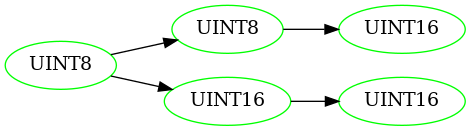

In [ ]:
TFT = FieldTree(y_syntaxes)
TFT.display()

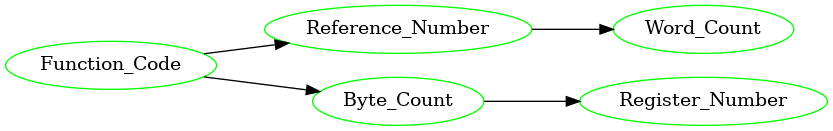

In [ ]:
# Same can be done for semantics
FieldTree(y_semantics).display()

### Testing the Packet Field Tree

id


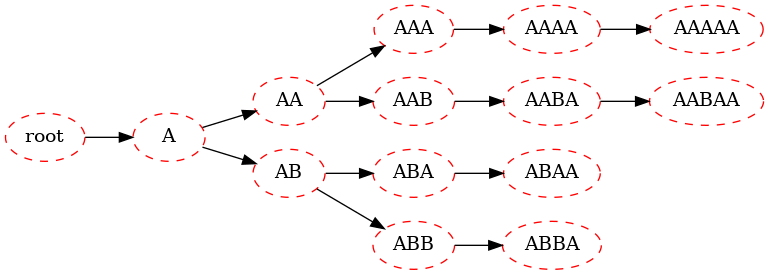

In [ ]:
pft1 = OneBytePFT(numeric_thresh=3, depth=10000)
pft1.fit(X)
pft1.show(attr='id')

type


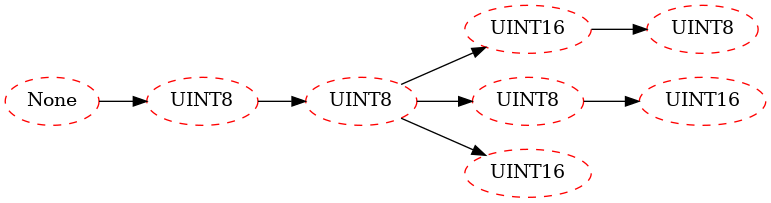

In [ ]:
# load the byte-syntax-probability model
model_file = f'src/PacketFeatureTree/ByteLabelModels/clf_{Protocol}.pkl'
pft2 = LabelledPFT(pft1, model_file)
pft2.fit()
pft2.show()

### Measuring Perfection Score

In [ ]:
pred_types, pred_lengths = pft2.transform(X[:1000])
perfections = [PER(F(bit_lengths=T), F(bit_lengths=P)) for T,P in zip(y_lengths, pred_lengths)]
f'Perfection for first 1000 packets: {sum(perfections)/len(perfections)}'

'Perfection for first 1000 packets: 0.6911764705882353'

### Measuring the PFT Score

In [ ]:
PN, TN, PND, TNI, score = FieldTreeScore(pft2.tree.children[0], TFT.tree)
f'Field Tree Score for {Protocol} is {score}: '

dist=2.0


'Field Tree Score for ModBus is 0.86: '

In [ ]:
PN, TN, PND, TNI

(7, 5, 2, 0)

## Add Custom Dissection

Create a new folder in src/APREdatabase/Protocols.
Each capture should exist in a subfolder, paired with the capture csv.
The main protocol format should contain the formats csv

```
Protocols/
    ModBus/
        ics-github/
            modbus_ics.csv
            modbus_ics.pcap
        netplier/
            modbus_100.csv
            modbus_100.csv
        modbus_formats.csv
```

See ModBus example below

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
capture_df.head()

,Timestamp,FormatID,Bytes
0,1.543698e+09,2513768672087828265,70f35a4273e8b8ca3a7b97d60800
1,1.543698e+09,2513768672087828265,b8ca3a7b97d670f35a4273e80800
2,1.543698e+09,2513768672087828265,b8ca3a7b97d670f35a4273e80800
3,1.543698e+09,2513768672087828265,b8ca3a7b97d670f35a4273e80800
4,1.543698e+09,2513768672087828265,b8ca3a7b97d670f35a4273e80800


In [ ]:
FormatsDF.head()

,FormatID,ListOfBitLengths,ListOfSyntaxes,ListOfSemantics
0,2239922534893689534,"[48, 48, 16]","['ETHER', 'ETHER', 'UINT16']","['Destination', 'Source', 'Type']"
1,7267344558023496520,"[48, 48, 16]","['ETHER', 'ETHER', 'UINT16']","['Destination', 'Source', 'Length']"
2,1034029894325062860,"[48, 48, 16]","['ETHER', 'ETHER', 'UINT16']","['Destination', 'Source', 'Type']"
3,6954088114639439875,"[48, 48, 16]","['ETHER', 'ETHER', 'UINT16']","['Destination', 'Source', 'Length']"
4,5389692369661918694,"[48, 48, 16]","['ETHER', 'ETHER', 'UINT16']","['Destination', 'Source', 'Type']"


## Acknowledgements for Packet Captures 

UNSW IoT Analytics Traces: https://iotanalytics.unsw.edu.au/iottraces.html

4SICS. Geek Lounge ICS Lab (CS3STHLM).
download.netresec.com/pcap/4sics-2015, 2015.

CISA. Industrial Control Systems Network Protocol
Parsers (ICSNPP). github.com/cisagov/ICSNPP, 2020.

Gerald Combs. Wireshark. wiki.wireshark.org, 1998.

SMIA. Swedish Defence Research Agency Information
Warfare Lab. download.netresec.com/pcap/smia-2011,
2011.

I. Sharafaldin, A. H. Lashkari, S. Hakak, and A. A. Ghor-
bani. Developing realistic distributed denial of service
(DDoS) attack dataset and taxonomy. In 2019 Inter-
national Carnahan Conference on Security Technology
(ICCST), pages 1–8, 2019.